Starting Meta-Training of Learned Optimizer 
Epoch 0, Avg Final Loss: 150.172620
Epoch 100, Avg Final Loss: 5.408149
Epoch 200, Avg Final Loss: 3.594532
Epoch 300, Avg Final Loss: 3.457139
Epoch 400, Avg Final Loss: 3.222175
Epoch 500, Avg Final Loss: 3.088380
Epoch 600, Avg Final Loss: 2.339123
Epoch 700, Avg Final Loss: 2.319096
Epoch 800, Avg Final Loss: 2.390990
Epoch 900, Avg Final Loss: 2.525800
Meta-Training Finished 

Starting Evaluation 
Evaluation Finished 


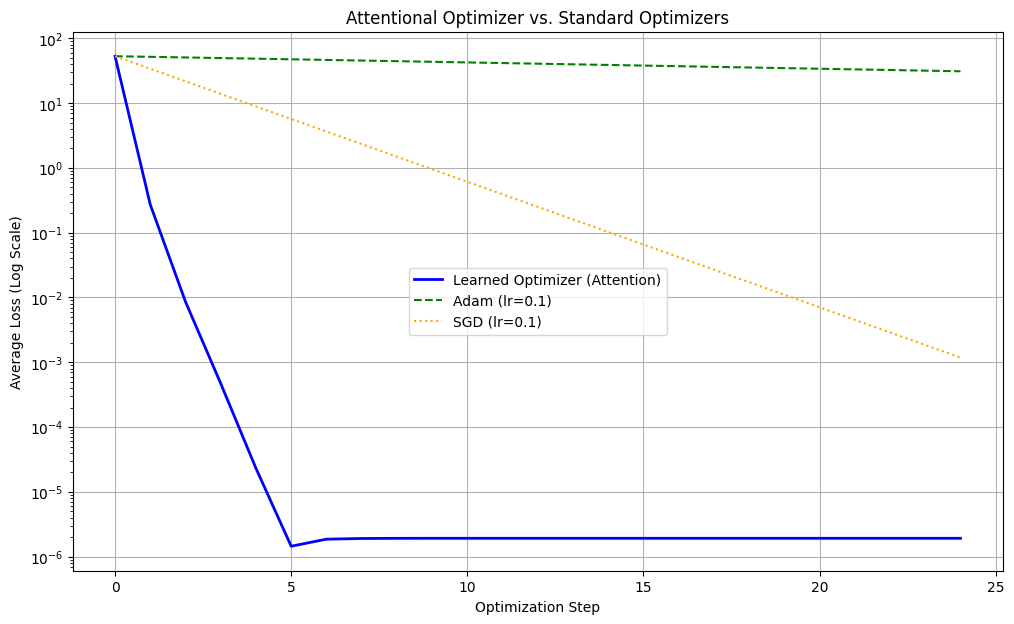

In [14]:
""" We've replaced the LSTM's "memory" with a small "Transformer block." This block has a "memory" (hidden_state) just like the LSTM."""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def f(x, target):
    return (x - target)**2

def grad_f(x, target):
    return 2 * (x - target)

# The NEW Learned Optimizer (Attention-Based)
# This network is a single Transformer-style decoder block.
class AttentionalOptimizer(nn.Module):
    def __init__(self, input_size=1, model_dim=20, num_heads=4, output_size=1):
        super(AttentionalOptimizer, self).__init__()
        self.model_dim = model_dim

        # 1. Embed the gradient into the model's dimension
        self.grad_embed = nn.Linear(input_size, model_dim)

        # 2. The core attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=model_dim,
                                               num_heads=num_heads,
                                               batch_first=True)
        # 3. Feed-Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(model_dim, model_dim * 4),
            nn.ReLU(),
            nn.Linear(model_dim * 4, model_dim)
        )

        # 4. Layer Normalization
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)

        self.output_layer = nn.Linear(model_dim, output_size)

    def forward(self, grad, hidden_state):
        # grad shape: [batch_size, 1]
        # hidden_state shape: [batch_size, 1, model_dim]

        # 1. Embed grad to create the "Query"
        # query shape: [batch_size, 1, model_dim]
        query = self.grad_embed(grad.unsqueeze(1))

        # 2. Apply Attention
        # The new grad (Query) "attends to" the old memory (Key/Value)
        attn_output, _ = self.attention(query, hidden_state, hidden_state)

        # 3. First Residual + Norm (like a Transformer)
        # Add the new info (query) to the attended output
        hidden_state = self.norm1(query + attn_output)

        # 4. Feed-Forward Network + Second Residual + Norm
        ffn_output = self.ffn(hidden_state)
        new_hidden_state = self.norm2(hidden_state + ffn_output)

        # 5. the final update step
        update_step = self.output_layer(new_hidden_state.squeeze(1))

        return update_step, new_hidden_state

meta_epochs = 1000
unroll_steps = 20
meta_lr = 0.01
batch_size = 128
model_dim = 20
# META-TRAINING


lopt = AttentionalOptimizer(model_dim=model_dim)
meta_optimizer = optim.Adam(lopt.parameters(), lr=meta_lr)

print("Starting Meta-Training of Learned Optimizer ")
lopt.train()

for epoch in range(meta_epochs):
    targets = torch.randn(batch_size, 1) * 5.0
    x = torch.randn(batch_size, 1) * 5.0

    hidden = torch.zeros(batch_size, 1, model_dim)

    total_loss_for_meta_update = 0


    for t in range(unroll_steps):
        loss = f(x, targets)
        grad = grad_f(x, targets)
        total_loss_for_meta_update += loss.mean()

        update_step, hidden = lopt(grad.detach(), hidden)

        x = x + update_step

    meta_optimizer.zero_grad()
    total_loss_for_meta_update.backward()
    meta_optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Avg Final Loss: {total_loss_for_meta_update.item() / unroll_steps:.6f}")

print("Meta-Training Finished ")


# EVALUATION LOOP

print("\nStarting Evaluation ")
lopt.eval()

for i in range(num_eval_problems):
    target = torch.randn(1, 1) * 5.0
    start_x = torch.randn(1, 1) * 5.0

    # Evaluator 1: Learned Optimizer
    with torch.no_grad():
        x_lopt = start_x.clone()


        h_lopt = torch.zeros(1, 1, model_dim)

        for t in range(eval_steps):
            loss = f(x_lopt, target)
            lopt_loss_history[i, t] = loss.item()
            grad = grad_f(x_lopt, target)

            update, h_lopt = lopt(grad, h_lopt)
            x_lopt = x_lopt + update

    # Evaluator 2: Standard SGD
    x_sgd = start_x.clone()
    for t in range(eval_steps):
        loss = f(x_sgd, target)
        sgd_loss_history[i, t] = loss.item()
        grad = grad_f(x_sgd, target)
        x_sgd = x_sgd - sgd_lr * grad

    # Evaluator 3: Standard Adam

    x_adam = nn.Parameter(start_x.clone())
    adam_optimizer = optim.Adam([x_adam], lr=adam_lr)
    for t in range(eval_steps):
        adam_optimizer.zero_grad()
        loss = f(x_adam, target)
        adam_loss_history[i, t] = loss.item()
        loss.backward()
        adam_optimizer.step()

print("Evaluation Finished ")

# PLOTTING THE COMPARISON

avg_lopt_loss = np.mean(lopt_loss_history, axis=0)
avg_sgd_loss = np.mean(sgd_loss_history, axis=0)
avg_adam_loss = np.mean(adam_loss_history, axis=0)

plt.figure(figsize=(12, 7))
plt.plot(avg_lopt_loss, label='Learned Optimizer (Attention)', color='blue', linewidth=2)
plt.plot(avg_adam_loss, label=f'Adam (lr={adam_lr})', color='green', linestyle='--')
plt.plot(avg_sgd_loss, label=f'SGD (lr={sgd_lr})', color='orange', linestyle=':')
plt.title('Attentional Optimizer vs. Standard Optimizers')
plt.xlabel('Optimization Step')
plt.ylabel('Average Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Training one neural network to learn how to optimize another neural network

#The Meta-Learning Model (LearnedOptimizer): This is the "Optimizer AI" (the LSTM). Its job is to learn how to optimize.
#It takes gradients as input and outputs parameter updates.

#The "Child" Model (ChildModel): This is the "Problem" (the 2-layer MLP). Its job is to learn to classify MNIST images.

Starting Meta-Training of Learned Optimizer 
Epoch 0, Meta-Loss: 141.809192
Epoch 10, Meta-Loss: 109.348950
Epoch 20, Meta-Loss: 115.118262
Epoch 30, Meta-Loss: 127.526294
Epoch 40, Meta-Loss: 79.302869
Epoch 50, Meta-Loss: 65.055609
Epoch 60, Meta-Loss: 126.405664
Epoch 70, Meta-Loss: 54.027484
Epoch 80, Meta-Loss: 56.020325
Epoch 90, Meta-Loss: 22.629614
Meta-Training Finished 

Starting Evaluation 
Evaluation Finished 


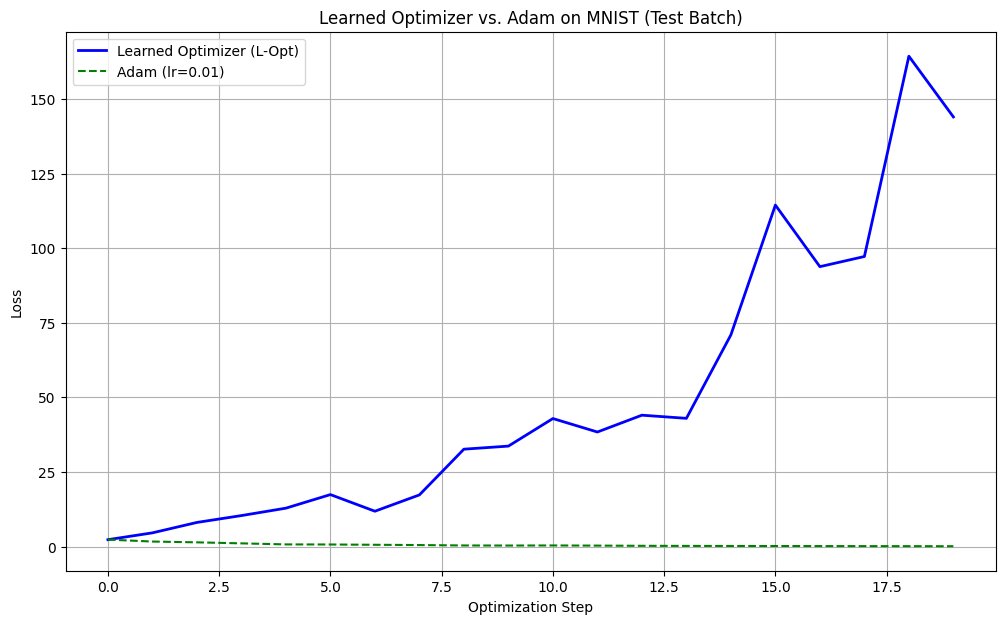

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# The Learned Optimizer (LSTM)
class LearnedOptimizer(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super(LearnedOptimizer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x_reshaped = x.unsqueeze(1)
        out, new_hidden_state = self.lstm(x_reshaped, hidden_state)
        update_step = self.output_layer(out.squeeze(1))
        return update_step, new_hidden_state

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to("cpu"),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to("cpu"))

# The "Child" Model (A Simple MLP for MNIST)
class ChildModel(nn.Module):
    """A simple 2-layer MLP for MNIST."""
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(ChildModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def functional_forward(x_flat, params):
    """
    A functional version of the ChildModel.
    'params' is a list: [fc1.weight, fc1.bias, fc2.weight, fc2.bias]
    """
    # Layer 1
    h = F.linear(x_flat, params[0], params[1])
    h = F.relu(h)
    # Layer 2
    out = F.linear(h, params[2], params[3])
    return out

meta_epochs = 100
unroll_steps = 10
meta_lr = 0.001
batch_size = 64

# Data Loaders MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

meta_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
meta_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)
meta_train_iter = iter(meta_train_loader)

# Meta-Training Loop
lopt_net = LearnedOptimizer(input_size=2, hidden_size=32).to("cpu")
meta_optimizer = optim.Adam(lopt_net.parameters(), lr=meta_lr)
criterion = nn.CrossEntropyLoss()

print("Starting Meta-Training of Learned Optimizer ")
lopt_net.train()

for epoch in range(meta_epochs):

    try:
        data, target = next(meta_train_iter)
    except StopIteration:
        meta_train_iter = iter(meta_train_loader)
        data, target = next(meta_train_iter)

    data, target = data.to("cpu"), target.to("cpu")
    data_flat = data.view(data.size(0), -1)

    # Initialize a new Child model and its state
    child_model_init = ChildModel().to("cpu")
    child_params = list(child_model_init.parameters())

    hidden_states = {}
    for i, p in enumerate(child_params):
        num_params = p.numel()
        hidden_states[i] = lopt_net.init_hidden(num_params)

    total_meta_loss = 0
    meta_optimizer.zero_grad()

    # The Inner Loop (Unrolling the optimization)
    for t in range(unroll_steps):

        # Calculate loss and gradient
        outputs = functional_forward(data_flat, child_params)
        loss = criterion(outputs, target)
        total_meta_loss += loss

        # Add create_graph=True and retain_graph=True
        grads = torch.autograd.grad(loss, child_params, create_graph=True, retain_graph=True)

        # Use the Learned Optimizer
        new_params = []
        for i, (p, g) in enumerate(zip(child_params, grads)):

            grad_flat = g.flatten().unsqueeze(-1) # Shape: [num_params, 1]
            p_flat = p.detach().flatten().unsqueeze(-1) # Shape: [num_params, 1]

            # [Combine grad and param]
            lopt_input = torch.cat((grad_flat, p_flat), dim=1) # Shape: [num_params, 2]

            h = hidden_states[i]

            # Feed in the combined input
            update_flat, new_h = lopt_net(lopt_input, h)

            hidden_states[i] = new_h

            update = update_flat.squeeze(-1).view_as(p)
            p_new = p + update
            new_params.append(p_new)

        child_params = new_params
    # The Meta-Update Step
    total_meta_loss.backward()
    meta_optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Meta-Loss: {total_meta_loss.item() / unroll_steps:.6f}")

print("Meta-Training Finished ")

print("\nStarting Evaluation ")
lopt_net.eval()

eval_steps = 20
adam_lr = 0.01

test_data, test_target = next(iter(meta_test_loader))
test_data, test_target = test_data.to("cpu"), test_target.to("cpu")
test_data_flat = test_data.view(test_data.size(0), -1)

lopt_loss_history = []
adam_loss_history = []

# Evaluator 1: Learned Optimizer (L-Opt)
lopt_child_model = ChildModel().to("cpu")
lopt_params = list(lopt_child_model.parameters())

lopt_hidden_states = {}
for i, p in enumerate(lopt_params):

    lopt_hidden_states[i] = lopt_net.init_hidden(p.numel())

for t in range(eval_steps):
    outputs = functional_forward(test_data_flat, lopt_params)
    loss = criterion(outputs, test_target)
    lopt_loss_history.append(loss.item())

    with torch.enable_grad():
        grads = torch.autograd.grad(loss, lopt_params)

    new_params = []
    with torch.no_grad():
        for i, (p, g) in enumerate(zip(lopt_params, grads)):

            grad_flat = g.flatten().unsqueeze(-1)
            # Get the parameter value as an input
            p_flat = p.flatten().unsqueeze(-1)

            # Combine them, just like in training
            lopt_input = torch.cat((grad_flat, p_flat), dim=1)

            h = lopt_hidden_states[i]

            # Feed the new 2-feature input
            update_flat, new_h = lopt_net(lopt_input, h)


            lopt_hidden_states[i] = new_h

            update = update_flat.squeeze(-1).view_as(p)
            p_new = p + update
            new_params.append(p_new)

    lopt_params = new_params

    for p in lopt_params:
        p.requires_grad = True

# Evaluator 2: Standard Adam
adam_child_model = ChildModel().to("cpu")
adam_optimizer = optim.Adam(adam_child_model.parameters(), lr=adam_lr)

for t in range(eval_steps):
    adam_optimizer.zero_grad()
    outputs = adam_child_model(test_data)
    loss = criterion(outputs, test_target)
    adam_loss_history.append(loss.item())
    loss.backward()
    adam_optimizer.step()

print("Evaluation Finished ")


# Plotting the Comparison
plt.figure(figsize=(12, 7))
plt.plot(lopt_loss_history, label='Learned Optimizer (L-Opt)', color='blue', linewidth=2)
plt.plot(adam_loss_history, label=f'Adam (lr={adam_lr})', color='green', linestyle='--')

plt.title('Learned Optimizer vs. Adam on MNIST (Test Batch)')
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Starting Meta-Training of Learned Optimizer
Epoch 0, Meta-Loss: 779.967285
Epoch 10, Meta-Loss: 149.706970
Epoch 20, Meta-Loss: 241.285229
Epoch 30, Meta-Loss: 149.292578
Epoch 40, Meta-Loss: 69.959692
Epoch 50, Meta-Loss: 31.640491
Epoch 60, Meta-Loss: 8.335411
Epoch 70, Meta-Loss: 3.867885
Epoch 80, Meta-Loss: 4.618468
Epoch 90, Meta-Loss: 3.483031
Meta-Training Finished

Starting Evaluation
Evaluation Finished


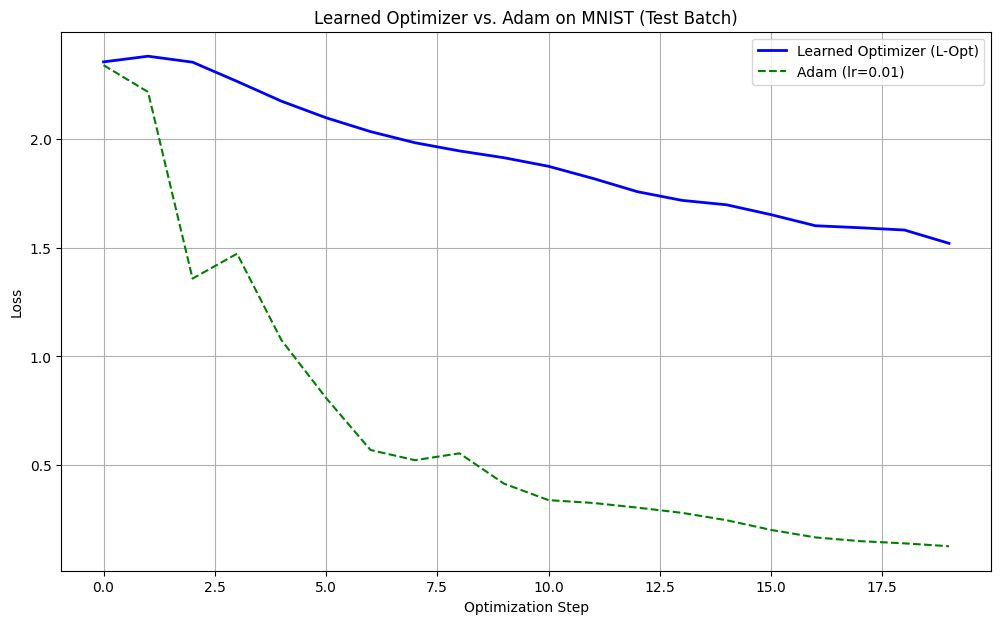

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


# The Learned Optimizer (LSTM)
class LearnedOptimizer(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, output_size=1):
        super(LearnedOptimizer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state):
        x_reshaped = x.unsqueeze(1)
        out, new_hidden_state = self.lstm(x_reshaped, hidden_state)
        update_step = self.output_layer(out.squeeze(1))
        return update_step, new_hidden_state

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to("cpu"),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to("cpu"))

# The Child Model (A Simple MLP for MNIST)
class ChildModel(nn.Module):
    """A simple 2-layer MLP for MNIST."""
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(ChildModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def functional_forward(x_flat, params):
    """
    A functional version of the ChildModel.
    'params' is a list: [fc1.weight, fc1.bias, fc2.weight, fc2.bias]
    """
    # Layer 1
    h = F.linear(x_flat, params[0], params[1])
    h = F.relu(h)
    # Layer 2
    out = F.linear(h, params[2], params[3])
    return out

meta_epochs = 100
unroll_steps = 10
meta_lr = 0.001
batch_size = 64

# Data Loaders (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

meta_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
meta_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)
meta_train_iter = iter(meta_train_loader)

# Meta-Training Loop
lopt_net = LearnedOptimizer(input_size=3, hidden_size=32).to("cpu")
meta_optimizer = optim.Adam(lopt_net.parameters(), lr=meta_lr)
criterion = nn.CrossEntropyLoss()

print("Starting Meta-Training of Learned Optimizer")
lopt_net.train()

for epoch in range(meta_epochs):

    try:
        data, target = next(meta_train_iter)
    except StopIteration:
        meta_train_iter = iter(meta_train_loader)
        data, target = next(meta_train_iter)

    data, target = data.to("cpu"), target.to("cpu")
    data_flat = data.view(data.size(0), -1)

    # Initialize a new Child model and its state
    child_model_init = ChildModel().to("cpu")
    child_params = list(child_model_init.parameters())

    hidden_states = {}
    prev_updates = {}
    for i, p in enumerate(child_params):
        num_params = p.numel()
        hidden_states[i] = lopt_net.init_hidden(num_params)
        prev_updates[i] = torch.zeros_like(p.flatten().unsqueeze(-1))

    total_meta_loss = 0
    meta_optimizer.zero_grad()


    for t in range(unroll_steps):

        # Calculate loss and gradient
        outputs = functional_forward(data_flat, child_params)
        loss = criterion(outputs, target)
        total_meta_loss += loss

        grads = torch.autograd.grad(loss, child_params, create_graph=True, retain_graph=True)

        # Use the Learned Optimizer
        new_params = []
        for i, (p, g) in enumerate(zip(child_params, grads)):

            grad_flat = g.flatten().unsqueeze(-1) 
            p_flat = p.detach().flatten().unsqueeze(-1) 
            prev_update_flat = prev_updates[i] 

            
            lopt_input = torch.cat((grad_flat, p_flat, prev_update_flat), dim=1) 

            h = hidden_states[i]

            # Feed in the combined input
            update_flat, new_h = lopt_net(lopt_input, h)

            hidden_states[i] = new_h

            update = update_flat.squeeze(-1).view_as(p)
            p_new = p + update
            new_params.append(p_new)

            prev_updates[i] = update_flat.detach() # Update prev_updates for next step

        child_params = new_params
    # Meta-Update Step
    total_meta_loss.backward()
    meta_optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Meta-Loss: {total_meta_loss.item() / unroll_steps:.6f}")

print("Meta-Training Finished")

print("\nStarting Evaluation")
lopt_net.eval()

eval_steps = 20
adam_lr = 0.01

test_data, test_target = next(iter(meta_test_loader))
test_data, test_target = test_data.to("cpu"), test_target.to("cpu")
test_data_flat = test_data.view(test_data.size(0), -1)

lopt_loss_history = []
adam_loss_history = []

# Evaluator 1: Learned Optimizer (L-Opt)
lopt_child_model = ChildModel().to("cpu")
lopt_params = list(lopt_child_model.parameters())

lopt_hidden_states = {}
lopt_prev_updates = {}
for i, p in enumerate(lopt_params):

    lopt_hidden_states[i] = lopt_net.init_hidden(p.numel())
    lopt_prev_updates[i] = torch.zeros_like(p.flatten().unsqueeze(-1))
for t in range(eval_steps):
    outputs = functional_forward(test_data_flat, lopt_params)
    loss = criterion(outputs, test_target)
    lopt_loss_history.append(loss.item())

    grads = torch.autograd.grad(loss, lopt_params, allow_unused=True)

    new_params = []
    for i, (p, g) in enumerate(zip(lopt_params, grads)):
        actual_grad = g if g is not None else torch.zeros_like(p)

        with torch.no_grad():
            grad_flat = actual_grad.flatten().unsqueeze(-1)
            p_flat = p.flatten().unsqueeze(-1)
            prev_update_flat = lopt_prev_updates[i] # Get previous update

            # Combine them, just like in training
            lopt_input = torch.cat((grad_flat, p_flat, prev_update_flat), dim=1)

            h = lopt_hidden_states[i]

            update_flat, new_h = lopt_net(lopt_input, h)

            lopt_hidden_states[i] = new_h

            update = update_flat.squeeze(-1).view_as(p)

        p_new = p + update
        new_params.append(p_new)
        lopt_prev_updates[i] = update_flat.detach() # Update prev_updates for next step

    lopt_params = new_params

# Evaluator 2: Standard Adam
adam_child_model = ChildModel().to("cpu")
adam_optimizer = optim.Adam(adam_child_model.parameters(), lr=adam_lr)

for t in range(eval_steps):
    adam_optimizer.zero_grad()
    outputs = adam_child_model(test_data)
    loss = criterion(outputs, test_target)
    adam_loss_history.append(loss.item())
    loss.backward()
    adam_optimizer.step()

print("Evaluation Finished")


# Plotting the Comparison
plt.figure(figsize=(12, 7))
plt.plot(lopt_loss_history, label='Learned Optimizer (L-Opt)', color='blue', linewidth=2)
plt.plot(adam_loss_history, label=f'Adam (lr={adam_lr})', color='green', linestyle='--')

plt.title('Learned Optimizer vs. Adam on MNIST (Test Batch)')
plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()